## Import libs

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_curve, auc

import tensorflow as tf

import cv2
import os

import numpy as np

## Load train, val and test data

In [37]:
labels = ['Kirmizi_Pistachio', 'Siirt_Pistachio']
img_size = 224
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1]
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [38]:
train = get_data('Pistachio_Image_Dataset_Train')
val = get_data('Pistachio_Image_Dataset_Val')
test = get_data('Pistachio_Image_Dataset_Test')

/tmp/ipykernel_4344/673422909.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


## Showing the distribution of data

<AxesSubplot:ylabel='count'>

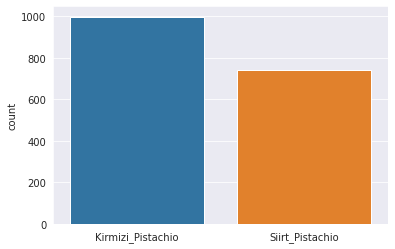

In [95]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Kirmizi_Pistachio")
    else:
        l.append("Siirt_Pistachio")
sns.set_style('darkgrid')
sns.countplot(x=l)

<AxesSubplot:ylabel='count'>

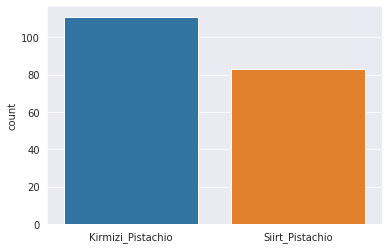

In [96]:
l = []
for i in val:
    if(i[1] == 0):
        l.append("Kirmizi_Pistachio")
    else:
        l.append("Siirt_Pistachio")
sns.set_style('darkgrid')
sns.countplot(x=l)

<AxesSubplot:ylabel='count'>

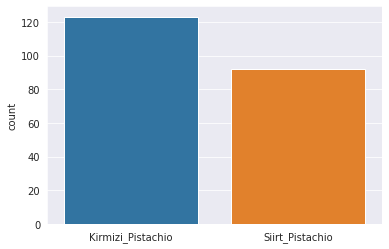

In [97]:
l = []
for i in test:
    if(i[1] == 0):
        l.append("Kirmizi_Pistachio")
    else:
        l.append("Siirt_Pistachio")
sns.set_style('darkgrid')
sns.countplot(x=l)

## Pre-Process Data and Data Augmentation

In [44]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []


for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in val:
  x_val.append(feature)
  y_val.append(label)
    
for feature, label in test:
  x_test.append(feature)
  y_test.append(label)

x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_val) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_val)

In [45]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

## Build the model

In [46]:
model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(224,224,3)))
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(2, activation="softmax"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 28, 28, 64)      

In [47]:
opt = Adam(learning_rate=0.000001)
model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

mode_autosave = tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True,monitor='val_loss',mode='min', verbose=0)
reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=80, verbose=1, min_delta=1e-4, mode='min')
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, verbose=0, mode='min')

## Training the model

In [48]:
epochs = 50

history = model.fit(x_train,y_train,epochs = epochs, validation_data = (x_val, y_val), callbacks=[mode_autosave,reduce_lr_loss,early_stopping])

Epoch 1/50


2022-06-19 17:39:17.563570: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1047072768 exceeds 10% of free system memory.
/home/alexandre/Mestrado/Aprendizagem de Maquina/ap/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


55/55 [==============================] - 51s 927ms/step - loss: 0.6821 - accuracy: 0.5693 - val_loss: 0.6755 - val_accuracy: 0.5619
Epoch 2/50
55/55 [==============================] - 52s 942ms/step - loss: 0.6628 - accuracy: 0.6256 - val_loss: 0.6552 - val_accuracy: 0.6082
Epoch 3/50
55/55 [==============================] - 48s 872ms/step - loss: 0.6487 - accuracy: 0.6550 - val_loss: 0.6323 - val_accuracy: 0.6598
Epoch 4/50
55/55 [==============================] - 53s 953ms/step - loss: 0.6318 - accuracy: 0.6774 - val_loss: 0.6106 - val_accuracy: 0.7216
Epoch 5/50
55/55 [==============================] - 51s 935ms/step - loss: 0.6117 - accuracy: 0.7062 - val_loss: 0.5888 - val_accuracy: 0.7577
Epoch 6/50
55/55 [==============================] - 53s 969ms/step - loss: 0.5953 - accuracy: 0.7401 - val_loss: 0.5691 - val_accuracy: 0.7732
Epoch 7/50
55/55 [==============================] - 55s 996ms/step - loss: 0.5775 - accuracy: 0.7407 - val_loss: 0.5512 - val_accuracy: 0.7629
Epoch 8/50

## Accuracy and Loss per Epoch

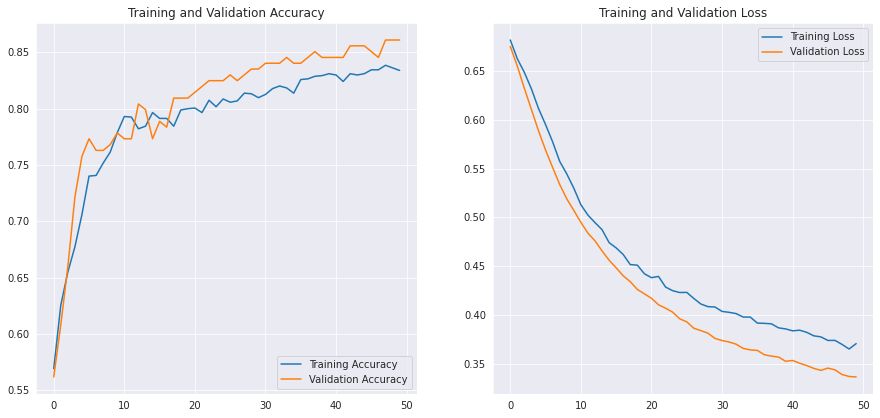

In [71]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Precision, Recall, F1-Score, Support and confusion_matrix

In [76]:
y_pred= model.predict(x_val) 
y_pred= np.argmax(y_pred,axis=1)
confusion_matrix(y_test, y_pred)
## TN FP
## FN TP
"""Thus in binary classification, the count of true negatives is
:math:`C_{0,0}`, false negatives is :math:`C_{1,0}`, true positives is
:math:`C_{1,1}` and false positives is :math:`C_{0,1}`."""

7/7 [==============================] - 1s 139ms/step


array([[96, 15],
       [12, 71]])

In [72]:
print(classification_report(y_test, y_pred, target_names = ['Kirimizi(Class 0)','Siirt (Class 1)']))

7/7 [==============================] - 1s 140ms/step
                   precision    recall  f1-score   support

Kirimizi(Class 0)       0.89      0.86      0.88       111
  Siirt (Class 1)       0.83      0.86      0.84        83

         accuracy                           0.86       194
        macro avg       0.86      0.86      0.86       194
     weighted avg       0.86      0.86      0.86       194



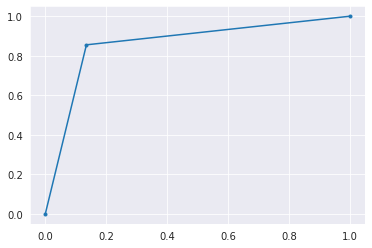

In [73]:
nn_fpr_keras, nn_tpr_keras, nn_thresholds_keras = roc_curve(y_test, y_pred)
auc_keras = auc(nn_fpr_keras, nn_tpr_keras)
plt.plot(nn_fpr_keras, nn_tpr_keras, marker='.', label='Neural Network (auc = %0.3f)' % auc_keras)